In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

### Scratch work

In [83]:
p_real = 0.3
sample_size = 100
candidate_mu = 0.5
lamb = 1.0  
T = 1000

X = scipy.stats.bernoulli.rvs(p_real, size=sample_size)
increments = np.exp(lamb*(X - candidate_mu) - (lamb**2)/8.0)
M = np.cumprod(increments).reshape(-1,1)

In [84]:
# Functional forms for lambda
def mean_hist(x,*args):
    return float(np.mean(x)) if len(x) else 0.0

def median_hist(x,*args):
    return float(np.median(x)) if len(x) else 0.0

def lam_hoeffding_closed(x_hist, m):
    xbar = mean_hist(x_hist)
    return 4.0 * (xbar - m)

def lam_online_grad(x_hist, m, lam_prev=0.0, eta=1.0, lam_max=10.0):
    xbar = mean_hist(x_hist)
    lam = lam_prev + eta*(xbar - m)
    return float(np.clip(lam, -lam_max, lam_max))

def lam_ema_plugin(x_hist, m, alpha=0.1):
    if len(x_hist) == 0:
        return 0.0
    ema = 0.0
    w = 0.0
    for x in x_hist:
        ema = alpha*x + (1-alpha)*ema
        w = alpha + (1-alpha)*w
    p_smooth = ema / max(w, 1e-12) 
    return 4.0 * (p_smooth - m)

In [85]:
lamb_func_list = [
    # mean_hist,
    # median_hist,
    lam_hoeffding_closed,     
    lam_online_grad,         
    lam_ema_plugin           
]

In [86]:
def run_lambdas(lamb_func_list, p_real=0.3, m=0.5, T=150, seed=7):
    rng = np.random.default_rng(seed)
    X = rng.binomial(1, p_real, size=T)  
    results = {}
    for lam_func in lamb_func_list:
        lam_values = []
        prev_lamb = 0.0
        for t in range(1, T+1):
            x_hist = X[:t]
            if lam_func.__name__ == "lam_online_grad":
                lam = lam_func(x_hist, m, lam_prev=prev_lamb)
            else:
                lam = lam_func(x_hist, m)
            lam_values.append(lam)
            prev_lamb = lam
        results[lam_func.__name__] = np.array(lam_values)
    return X, results


In [87]:
def hoeffding_process(X, lambdas, m):
    increments = np.exp(lambdas * (X - m) - (lambdas**2) / 8.0)  
    M = np.empty(len(increments) + 1, dtype=float)
    M[0] = 1.0
    M[1:] = np.cumprod(increments)
    return M  

In [88]:
p_real = 0.3
m = 0.5
T = 150

In [89]:
X, results = run_lambdas(lamb_func_list, p_real=p_real, m=m, T=T, seed=42)
tgrid = np.arange(1, T+1)

In [90]:
M_results = {}
for name, lambdas in results.items():
    M_results[name] = hoeffding_process(X, lambdas, m)

In [91]:
names = list(results.keys())
pairs = []
for i in range(len(names)):
    for j in range(i+1, len(names)):
        pairs.append((names[i], names[j]))

In [92]:
# for a, b in pairs:
#     lam_a = np.concatenate([[0.0], results[a]])
#     lam_b = np.concatenate([[0.0], results[b]])
#     tgrid_lam = np.arange(len(lam_a)) 
    
#     plt.figure(figsize=(8, 4.5))
#     plt.plot(tgrid_lam, lam_a, label=a)
#     plt.plot(tgrid_lam, lam_b, label=b)
#     plt.xlabel(r"$t$")
#     plt.ylabel(r"$\lambda_t$")
#     plt.title(rf" $\lambda_t$: {a} vs {b}")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
    
#     M_a = M_results[a]
#     M_b = M_results[b]
#     tgrid_M = np.arange(len(M_a))
    
#     plt.figure(figsize=(8, 4.5))
#     plt.plot(tgrid_M, np.log(M_a + 1e-300), label=a)
#     plt.plot(tgrid_M, np.log(M_b + 1e-300), label=b)
#     plt.xlabel(r"$t$")
#     plt.ylabel(r"$\log M_t$")
#     plt.title(rf"$\log M_t$: {a} vs {b}")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

### Predictale Plug-in Methods

In [93]:
# Fixed Sample Size!
def ci_PrPI_H_fixed(x,lmbd,alpha,psi):
    predictor_sum = np.sum(lmbd)
    interval_size = (np.log(2/alpha) + np.sum(psi(lmbd)))/predictor_sum
    center = (x @ lmbd)/interval_size
    return center-interval_size, center+ interval_size

def ci_Pl_EB_fixed(x,lamb,alpha,v,psi):
    predictor_sum = np.sum(lamb)
    interval_size = (np.log(2/alpha) + np.sum(v*psi(lamb)))/predictor_sum
    center = (x @ lamb)/interval_size
    return center - interval_size, center + interval_size

In [94]:
def cs_PrPl_H(x, lambdas, alpha, psi):
    x = np.asarray(x, float).ravel()
    lambdas = np.asarray(lambdas, float).ravel()
    num = np.cumsum(lambdas * x)               
    den = np.cumsum(lambdas)                   
    interval_size = (np.log(2/alpha) + np.cumsum(psi(lambdas))) / den
    center = num / den
    return center - interval_size, center + interval_size

def cs_PrPl_EB(x, lambdas, alpha, variances, psi):
    x = np.asarray(x, float).ravel()
    lambdas = np.asarray(lambdas, float).ravel()
    variances = np.asarray(variances, float).ravel()
    num = np.cumsum(lambdas * x)                 
    den = np.cumsum(lambdas)                  
    interval_size = (np.log(2/alpha) + np.cumsum(variances * psi(lambdas))) / den
    center = num / den
    return center - interval_size, center + interval_size



In [95]:
def plot_cs_three_panel(x, lambdas, alpha, psi, variances=None, label=None, bins=40):
    x = np.asarray(x, float).ravel()
    lambdas = np.asarray(lambdas, float).ravel()
    t = np.arange(1, x.size+1)

    if variances is None:
        L, U = cs_PrPl_H(x, lambdas, alpha, psi)
    else:
        variances = np.asarray(variances, float).ravel()
        L, U = cs_PrPl_EB(x, lambdas, alpha, variances, psi)

    widths = U - L
    print(widths)
    center = (L + U) / 2

    fig, axs = plt.subplots(1, 3, figsize=(13, 4))

    vals = np.unique(x)
    if vals.size <= 10 and np.all(np.mod(vals, 1) == 0):
        probs = [(x == v).mean() for v in vals]
        axs[0].bar(vals, probs, width=0.2)
        axs[0].set_ylabel("pmf")
    else:
        axs[0].hist(x, bins=bins, density=True)
        axs[0].set_ylabel("pdf")
    axs[0].set_title(r"$X_i$ data")

    axs[1].fill_between(t, L, U, alpha=0.6, label=label or "CS")
    axs[1].plot(t, center, "k--", lw=1)
    axs[1].set_xscale("log")
    axs[1].set_xlabel("time t")
    axs[1].set_ylabel("confidence sequence")
    if label is not None:
        axs[1].legend()

    axs[2].plot(t, widths)
    axs[2].set_xscale("log")
    axs[2].set_xlabel("time t")
    axs[2].set_ylabel("CS width")

    fig.tight_layout()
    plt.show()


[7.38025891e+01 3.69137945e+01 2.46175297e+01 ... 2.86892484e-02
 2.86890639e-02 2.86888795e-02]


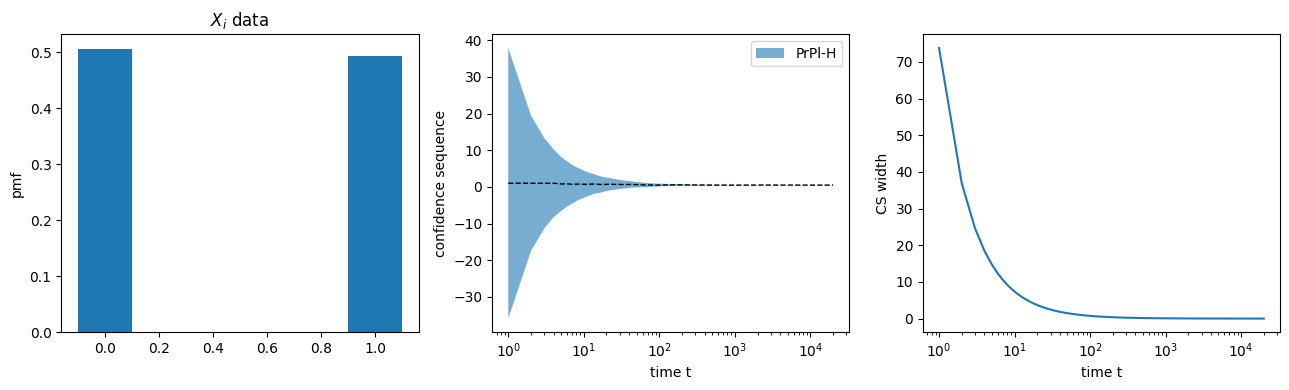

[7.38034512e+01 3.69146566e+01 2.46183918e+01 ... 2.95513173e-02
 2.95511329e-02 2.95509484e-02]


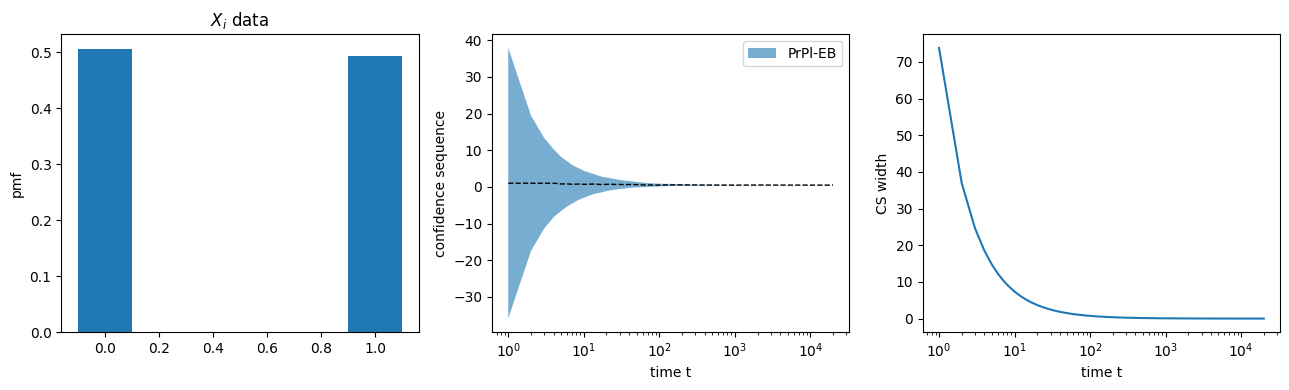

In [96]:
error_tolerance = 0.05
sample_size = np.linspace(100, 20000, 1000)

def psi_hoeff(lmbd):
    return (lmbd**2)/8

np.random.seed(0)
x = np.random.binomial(1, 0.5, int(sample_size.max()))
lambdas = np.full_like(x, 0.1, float)

plot_cs_three_panel(x, lambdas, error_tolerance, psi_hoeff, label="PrPl-H")

def psi_bernstein(lmbd, c=1.0):
    return (lmbd**2) / (2*(1 - (lmbd*c)/3))

v = np.full_like(x, 0.25, float)  
plot_cs_three_panel(x, lambdas, error_tolerance, lambda l: psi_bernstein(l, c=1.0),
                    variances=v, label="PrPl-EB")


### Capital Process


In [ ]:
def agrappa_lambda(emp_mean, emp_var, null_mean, c=0.99, eps=1e-6, ridge=1e-12):

    numerator = emp_mean - null_mean
    denominator = emp_var + (emp_mean - null_mean)**2 + ridge
    ratio = numerator / denominator

    lower_bound = -(1.0 - eps) / (1.0 - null_mean)
    upper_bound = (1.0 - eps) * (c / null_mean)

    return min(max(ratio, lower_bound), upper_bound)


def agrappa_capital_process(data, null_mean=0.5, c=0.99, warmup=2):
    data = np.asarray(data, float)
    capital = 1.0
    running_mean = 0.0
    sum_sq_dev = 0.0
    sample_size = 0

    for t, observation in enumerate(data, 1):
        prev_mean = running_mean if sample_size > 0 else null_mean
        prev_var = (sum_sq_dev / sample_size) if sample_size > 1 else 0.0

        lam = 0.0 if t <= warmup else agrappa_lambda(prev_mean, prev_var, null_mean, c)

        factor = 1.0 + lam * (observation - null_mean)
        if factor <= 0.0:
            factor = 1e-15  
        capital *= factor

        sample_size += 1
        delta = observation - running_mean
        running_mean += delta / sample_size
        sum_sq_dev += delta * (observation - running_mean)

    return capital


np.random.seed(0)
m = 0.5

x0 = np.random.binomial(1, m,   size=10) # H0
x1 = np.random.binomial(1, 0.7, size=10) # H1
print("K_T sob H0 (samples size 10):", agrappa_capital_process(x0, null_mean=m, c=0.99, warmup=2))
print("K_T sob H1(samples size 10):", agrappa_capital_process(x1, null_mean=m, c=0.99, warmup=2)) # bem baixin!
print()

x0 = np.random.binomial(1, m,   size=50) # H0
x1 = np.random.binomial(1, 0.7, size=50) # H1
print("K_T sob H0 (samples size 50):", agrappa_capital_process(x0, null_mean=m, c=0.99, warmup=2))
print("K_T sob H1(samples size 50):", agrappa_capital_process(x1, null_mean=m, c=0.99, warmup=2)) # bem baixin!
print()

x0 = np.random.binomial(1, m,   size=100) # H0
x1 = np.random.binomial(1, 0.7, size=100) # H1
print("K_T sob H0 (samples size 100):", agrappa_capital_process(x0, null_mean=m, c=0.99, warmup=2))
print("K_T sob H1(samples size 100):", agrappa_capital_process(x1, null_mean=m, c=0.99, warmup=2)) # bem baixin!
print()

x0 = np.random.binomial(1, m,   size=500) # H0
x1 = np.random.binomial(1, 0.7, size=500) # H1
print("K_T sob H0 (samples size 500):", agrappa_capital_process(x0, null_mean=m, c=0.99, warmup=2))
print("K_T sob H1(samples size 500):", agrappa_capital_process(x1, null_mean=m, c=0.99, warmup=2)) # bem baixin!




K_T sob H0 (samples size 10): 0.020116764999854767
K_T sob H1(samples size 10): 0.4063492063513056

K_T sob H0 (samples size 50): 0.0025745694960001026
K_T sob H1(samples size 50): 82.45310919444505

K_T sob H0 (samples size 100): 0.0026975359283114473
K_T sob H1(samples size 100): 48.638688602227546

K_T sob H0 (samples size 500): 5.362314471332645e-07
K_T sob H1(samples size 500): 81287363.05558021
